#ESG Emissions Predictor: Predicting Corporate Emissions for Modern ESG Reporting

Project Type - Supervised ML Regression

Contribution - Individual

Name - Subhadeep Purkayastha

# **Problem Statement**

Many companies still don’t disclose timely or complete greenhouse-gas (GHG) emissions. This creates gaps for ESG reporting, risk assessment, and carbon-market decisions. Using only upstream, readily available data (production volume, commodity, parent type, units) and without leaking downstream component emissions we need to predict total corporate CO₂e (entity-year) so stakeholders can estimate or validate emissions when disclosures are missing, lagged, or inconsistent.

# **Project Objective**

The objective of this project is to deliver a reliable, explainable **ESG emissions predictor** that will estimate a company’s annual total CO₂e from readily available operational inputs, so stakeholders will be able to act even when disclosures are missing, late, or inconsistent. It will provide credible point estimates with defensible confidence bounds, enabling investors to assess climate risk and portfolio exposure, regulators and auditors to validate reported numbers, and companies to benchmark peers and plan reductions. The model will expand market coverage, support carbon-credit and target-setting workflows, flag anomalous reporters, and power rapid “what-if” scenarios all in a transparent, audit-friendly way aligned with 2025 ESG reporting needs.

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.0 MB/s eta 0:00:00


Import Libraries

In [2]:
# Libraries which will be used in the project
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & feature engineering
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
    PowerTransformer
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Model selection & evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Statistical modeling
import statsmodels.api as sm

# Explainability
import shap

# Hyperparameter tuning
import optuna

# Utilities
from sklearn.base import clone
import joblib
import scipy

In [3]:
# import warnings
import warnings
warnings.filterwarnings('ignore')

Dataset Loading

In [4]:
from google.colab import files
uploaded = files.upload()

Saving emissions_high_granularity.csv to emissions_high_granularity.csv


Reading the file

In [5]:
df = pd.read_csv('emissions_high_granularity.csv')

Dataset View

In [6]:
df.head()

,year,parent_entity,parent_type,lei,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,source
0,1962,Abu Dhabi National Oil Company,State-owned Entity,5493009O1JMLWDLTIC26,Abu Dhabi,Oil & NGL,0.9125,Million bbl/yr,0.338928,0.005404,0.001299,0.0,0.018254,0.000652,0.024957,0.363885,Abu Dhabi National Oil Company Annual Report 1...
1,1963,Abu Dhabi National Oil Company,State-owned Entity,5493009O1JMLWDLTIC26,Abu Dhabi,Oil & NGL,1.8250,Million bbl/yr,0.677855,0.010808,0.002598,0.0,0.036508,0.001304,0.049914,0.727770,Abu Dhabi National Oil Company Annual Report 1...
2,1964,Abu Dhabi National Oil Company,State-owned Entity,5493009O1JMLWDLTIC26,Abu Dhabi,Oil & NGL,7.3000,Million bbl/yr,2.711422,0.043233,0.010392,0.0,0.146033,0.005215,0.199657,2.911079,Abu Dhabi National Oil Company Annual Report 1...
3,1965,Abu Dhabi National Oil Company,State-owned Entity,5493009O1JMLWDLTIC26,Abu Dhabi,Oil & NGL,10.9500,Million bbl/yr,4.067132,0.064849,0.015588,0.0,0.219049,0.007823,0.299486,4.366618,Abu Dhabi National Oil Company Annual Report 1...
4,1966,Abu Dhabi National Oil Company,State-owned Entity,5493009O1JMLWDLTIC26,Abu Dhabi,Oil & NGL,13.5050,Million bbl/yr,5.016130,0.079980,0.019225,0.0,0.270160,0.009649,0.369366,5.385495,Abu Dhabi National Oil Company Annual Report 1...


In [7]:
df.tail()

,year,parent_entity,parent_type,lei,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,source
19181,2021,YPF,State-owned Entity,5493003N7447U18U5U53,YPF,Natural Gas,403.0,Bcf/yr,21.533801,0.037373,0.614440,1.233120,5.956093,0.212718,7.841026,29.374827,"YPF Form 20-F for 2021, page 36."
19182,2022,YPF,State-owned Entity,5493003N7447U18U5U53,YPF,Oil & NGL,98.0,Million bbl/yr,36.399906,0.580383,0.139506,0.000000,1.960438,0.070016,2.680328,39.080234,"YPF Form 20-F for 2022, page 38."
19183,2022,YPF,State-owned Entity,5493003N7447U18U5U53,YPF,Natural Gas,423.0,Bcf/yr,22.602476,0.039228,0.644933,1.294317,6.251681,0.223274,8.230159,30.832635,"YPF Form 20-F for 2022, page 38."
19184,2023,YPF,State-owned Entity,5493003N7447U18U5U53,YPF,Oil & NGL,105.0,Million bbl/yr,38.999900,0.621839,0.149471,0.000000,2.100470,0.075017,2.871779,41.871679,"YPF Form 20-F for 2023, page 31."
19185,2023,YPF,State-owned Entity,5493003N7447U18U5U53,YPF,Natural Gas,414.0,Bcf/yr,22.121572,0.038393,0.631211,1.266778,6.118667,0.218524,8.055049,30.176622,"YPF Form 20-F for 2023, page 31."


Dataset Rows & Columns count

In [8]:
# Dataset Rows & Columns count
print("data observations: ",df.shape)

data observations:  (19186, 17)


Dataset Information

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19186 entries, 0 to 19185
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                19186 non-null  int64  
 1   parent_entity                       19186 non-null  object 
 2   parent_type                         19186 non-null  object 
 3   lei                                 13531 non-null  object 
 4   reporting_entity                    19186 non-null  object 
 5   commodity                           19186 non-null  object 
 6   production_value                    19186 non-null  float64
 7   production_unit                     19186 non-null  object 
 8   product_emissions_MtCO2             19186 non-null  float64
 9   flaring_emissions_MtCO2             19186 non-null  float64
 10  venting_emissions_MtCO2             19186 non-null  float64
 11  own_fuel_use_emissions_MtCO2        19186

Understanding Variables

In [10]:
# Dataset Columns
print(df.columns)

Index(['year', 'parent_entity', 'parent_type', 'lei', 'reporting_entity',
       'commodity', 'production_value', 'production_unit',
       'product_emissions_MtCO2', 'flaring_emissions_MtCO2',
       'venting_emissions_MtCO2', 'own_fuel_use_emissions_MtCO2',
       'fugitive_methane_emissions_MtCO2e', 'fugitive_methane_emissions_MtCH4',
       'total_operational_emissions_MtCO2e', 'total_emissions_MtCO2e',
       'source'],
      dtype='object')


In [11]:
# Dataset Describe
df.describe(include='all')

,year,parent_entity,parent_type,lei,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,source
count,19186.000000,19186,19186,13531,19186,19186,19186.000000,19186,19186.000000,19186.000000,19186.000000,19186.000000,19186.000000,19186.000000,19186.000000,19186.000000,19119
unique,NaN,180,3,134,482,9,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2844
top,NaN,Chevron,Investor-owned Company,WPTL2Z3FIYTHSP5V2253,Westmoreland Coal Company,Oil & NGL,NaN,Million tonnes/yr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No source as data is interpolated
freq,NaN,1041,11014,676,495,5742,NaN,7996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2590
mean,1990.729594,NaN,NaN,NaN,NaN,NaN,277.846137,NaN,63.844433,0.437766,0.394114,0.588373,7.151526,0.255412,8.571780,72.416213,NaN
std,28.212616,NaN,NaN,NaN,NaN,NaN,1093.149174,NaN,153.903019,1.645809,1.661823,3.275647,19.790466,0.706802,24.236947,173.187490,NaN
min,1854.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,1976.000000,NaN,NaN,NaN,NaN,NaN,7.400000,NaN,5.684134,0.000000,0.000000,0.000000,0.575577,0.020556,0.687563,6.692157,NaN
50%,1999.000000,NaN,NaN,NaN,NaN,NaN,37.110980,NaN,19.345595,0.005428,0.014969,0.000000,2.153179,0.076899,2.555177,22.506951,NaN
75%,2012.000000,NaN,NaN,NaN,NaN,NaN,182.144524,NaN,55.008595,0.128237,0.242182,0.028717,6.532656,0.233309,7.811841,63.805229,NaN


Check Unique Values for each variable

In [12]:
print("unique values in dataset:\n",df.nunique())

unique values in dataset:
 year                                    170
parent_entity                           180
parent_type                               3
lei                                     134
reporting_entity                        482
commodity                                 9
production_value                      16717
production_unit                           4
product_emissions_MtCO2               17703
flaring_emissions_MtCO2                9698
venting_emissions_MtCO2                9669
own_fuel_use_emissions_MtCO2           4646
fugitive_methane_emissions_MtCO2e     17385
fugitive_methane_emissions_MtCH4      17339
total_operational_emissions_MtCO2e    17374
total_emissions_MtCO2e                17730
source                                 2844
dtype: int64


Check Duplicate Values

In [13]:
# Dataset Duplicate Value Count
print("Duplicate Values in the dataset : ",df.duplicated().sum())

Duplicate Values in the dataset :  0


Check Missing Values

In [14]:
# Missing Values/Null Values Count
print(df.isnull().sum())

year                                     0
parent_entity                            0
parent_type                              0
lei                                   5655
reporting_entity                         0
commodity                                0
production_value                         0
production_unit                          0
product_emissions_MtCO2                  0
flaring_emissions_MtCO2                  0
venting_emissions_MtCO2                  0
own_fuel_use_emissions_MtCO2             0
fugitive_methane_emissions_MtCO2e        0
fugitive_methane_emissions_MtCH4         0
total_operational_emissions_MtCO2e       0
total_emissions_MtCO2e                   0
source                                  67
dtype: int64


Visualise missing data

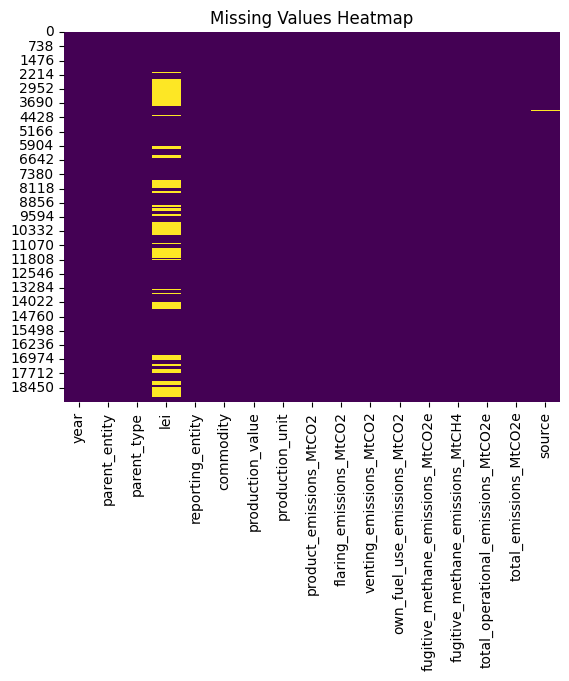

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

###Exploratory Data Analysis (EDA)###

Prepare data for EDA

'lei' (Legal Entity Identifier) is just a unique code per company, it won’t help you spot trends or distributions in emissions.

'source' is the textual reference (e.g. “Annual Report 2020”) and is mostly missing, it doesn’t drive emissions values.

'parent_entity' and 'reporting_entity' are company names or sub‑entity names. They’re high‑cardinality (lots of distinct values), so plotting them or summarizing them at this stage typically just creates noise. By dropping them, our visuals focus on the real drivers (like year, commodity, emission components) rather than on “who” reported the data.

In [16]:
eda_df = df.drop(columns=["lei", "source", "parent_entity", "reporting_entity"])
eda_df["production_unit"] = eda_df["production_unit"].astype(str).str.strip()

Missing Values Summary

In [17]:
missing = eda_df.isnull().sum()
missing_df = pd.DataFrame({
    "Missing Count": missing,
    "Missing %": (missing / len(eda_df) * 100).round(2)
})
display(missing_df)

,Missing Count,Missing %
year,0,0.0
parent_type,0,0.0
commodity,0,0.0
production_value,0,0.0
production_unit,0,0.0
product_emissions_MtCO2,0,0.0
flaring_emissions_MtCO2,0,0.0
venting_emissions_MtCO2,0,0.0
own_fuel_use_emissions_MtCO2,0,0.0
fugitive_methane_emissions_MtCO2e,0,0.0


Record Count by Year

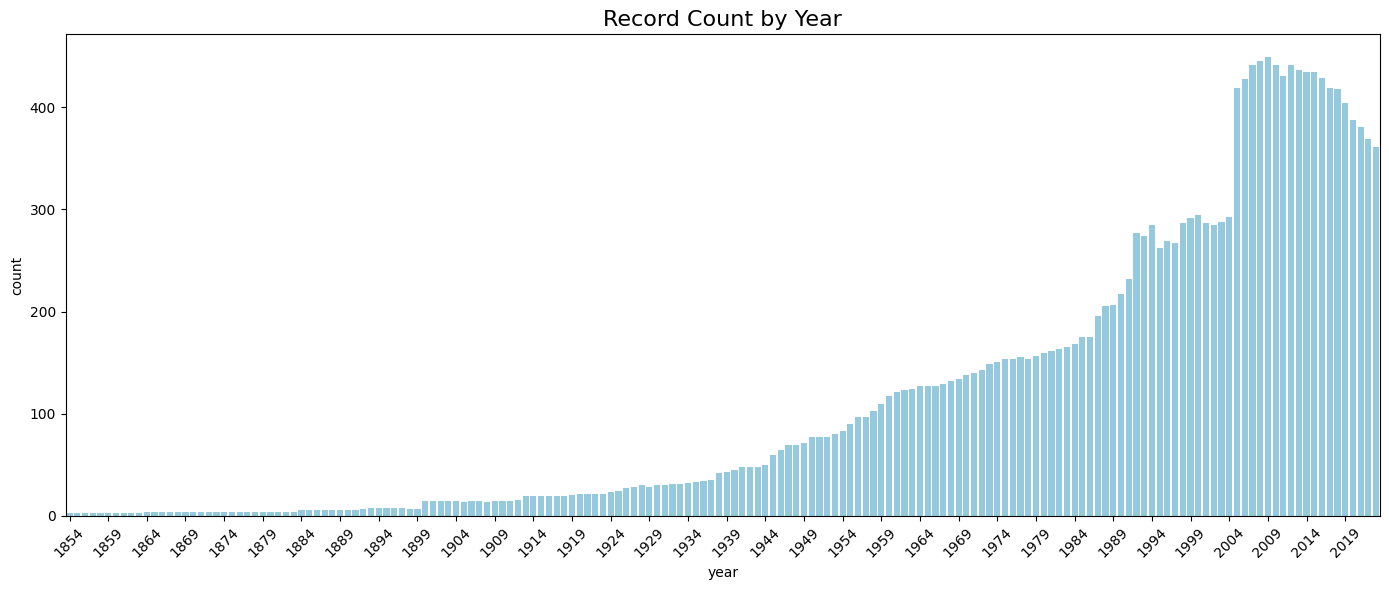

In [20]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x="year", color="skyblue")
plt.title("Record Count by Year", fontsize=16)

# Show only every 5th year label
ticks = plt.xticks()[0]
labels = plt.xticks()[1]
plt.xticks(ticks[::5], [label.get_text() for label in labels][::5], rotation=45)

plt.tight_layout()
plt.show()

Parent Type Distribution

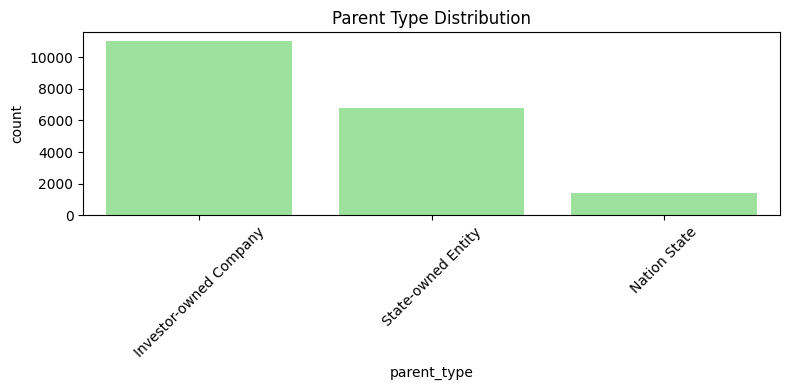

In [19]:
plt.figure(figsize=(8, 4))
sns.countplot(data=eda_df, x="parent_type", order=eda_df["parent_type"].value_counts().index, color="lightgreen")
plt.title("Parent Type Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Top 10 Commodities

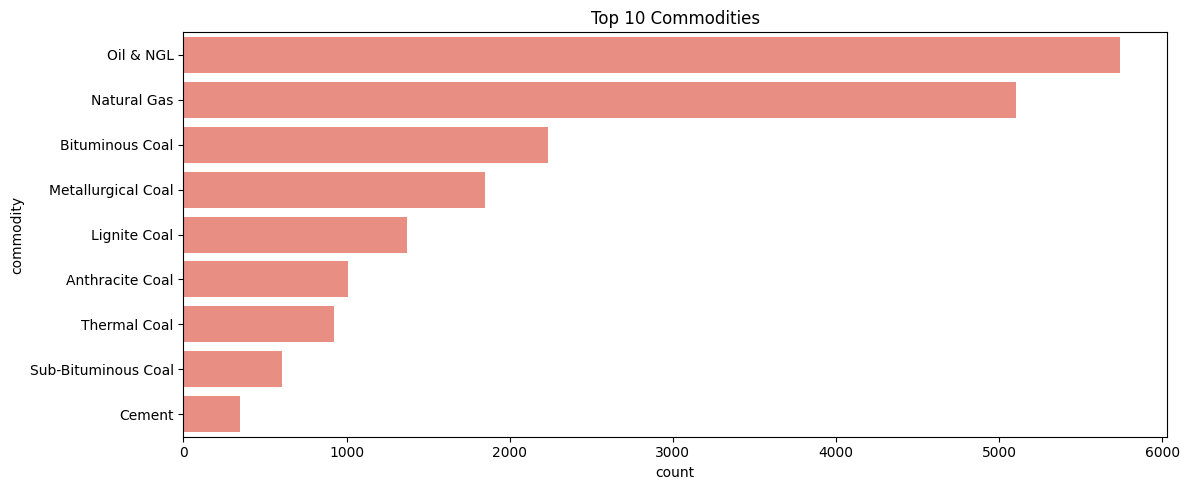

In [21]:
top_commodities = eda_df["commodity"].value_counts().nlargest(10).index
plt.figure(figsize=(12, 5))
sns.countplot(data=eda_df[eda_df["commodity"].isin(top_commodities)],
              y="commodity", order=top_commodities, color="salmon")
plt.title("Top 10 Commodities")
plt.tight_layout()
plt.show()

Distribution of Key Numeric Variables

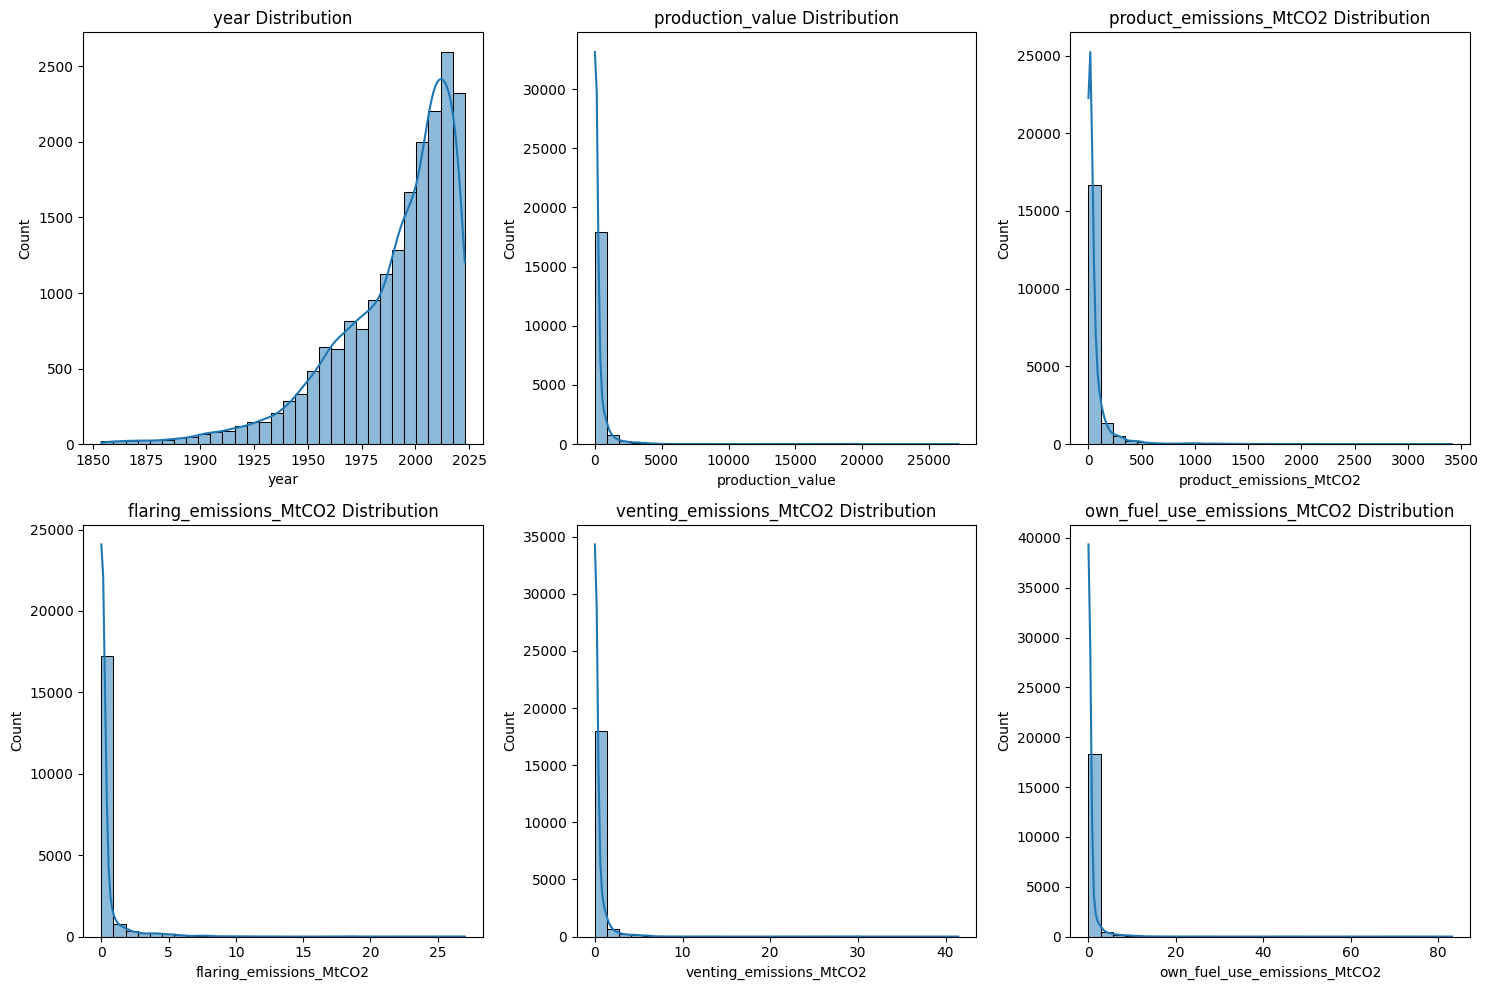

In [22]:
num_cols = eda_df.select_dtypes(include=["float64", "int64"]).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(eda_df[col], kde=True, bins=30)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

Total Emissions Distribution

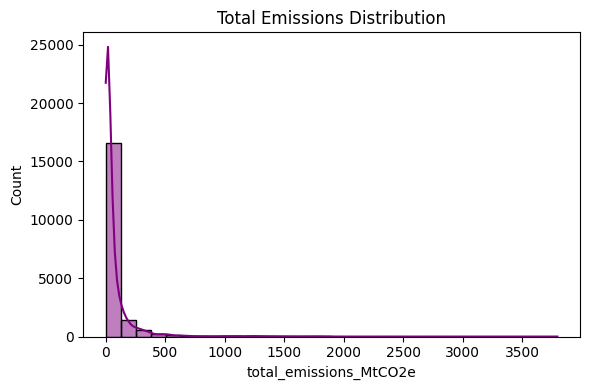

In [23]:
plt.figure(figsize=(6, 4))
sns.histplot(eda_df["total_emissions_MtCO2e"], kde=True, bins=30, color="purple")
plt.title("Total Emissions Distribution")
plt.tight_layout()
plt.show()

Production Value vs Emissions Scatter

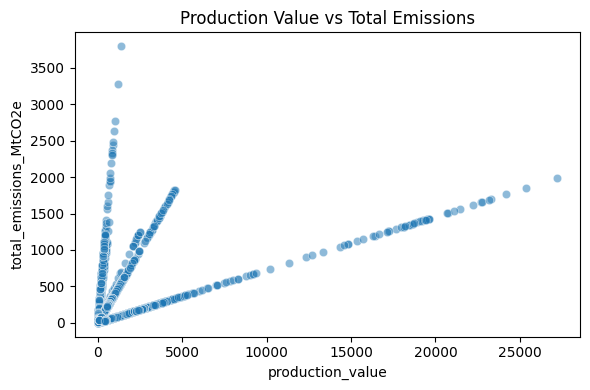

In [24]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=eda_df, x="production_value", y="total_emissions_MtCO2e", alpha=0.5)
plt.title("Production Value vs Total Emissions")
plt.tight_layout()
plt.show()

Correlation Matrix

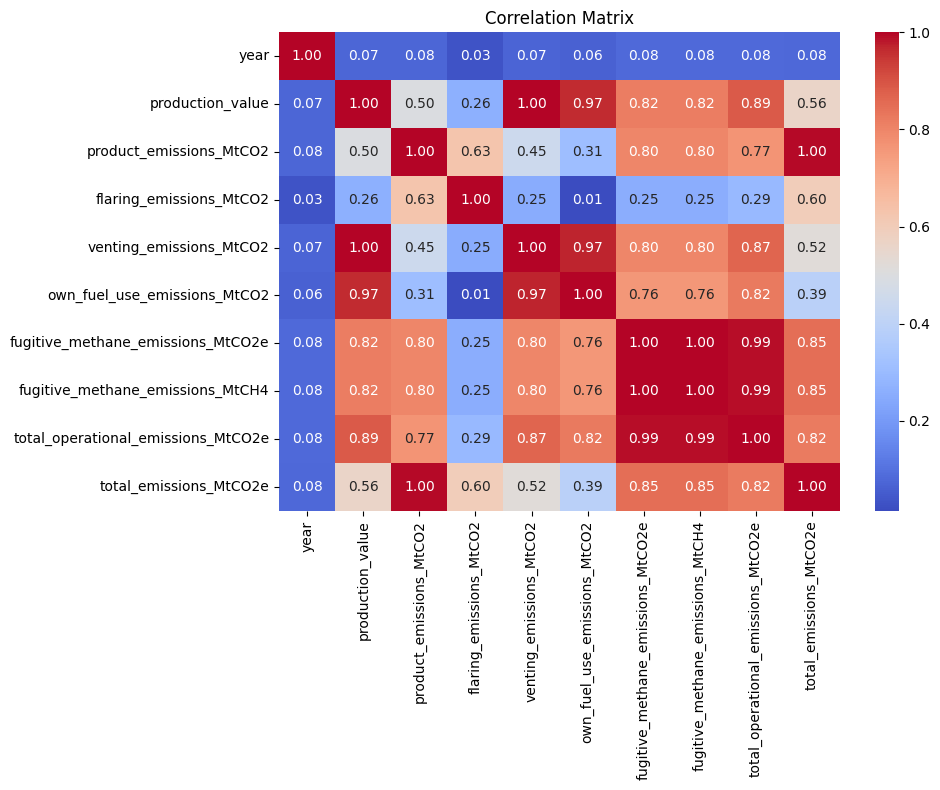

In [25]:
corr = eda_df.select_dtypes(include=["float64", "int64"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Emissions by Commodity (Top 5)

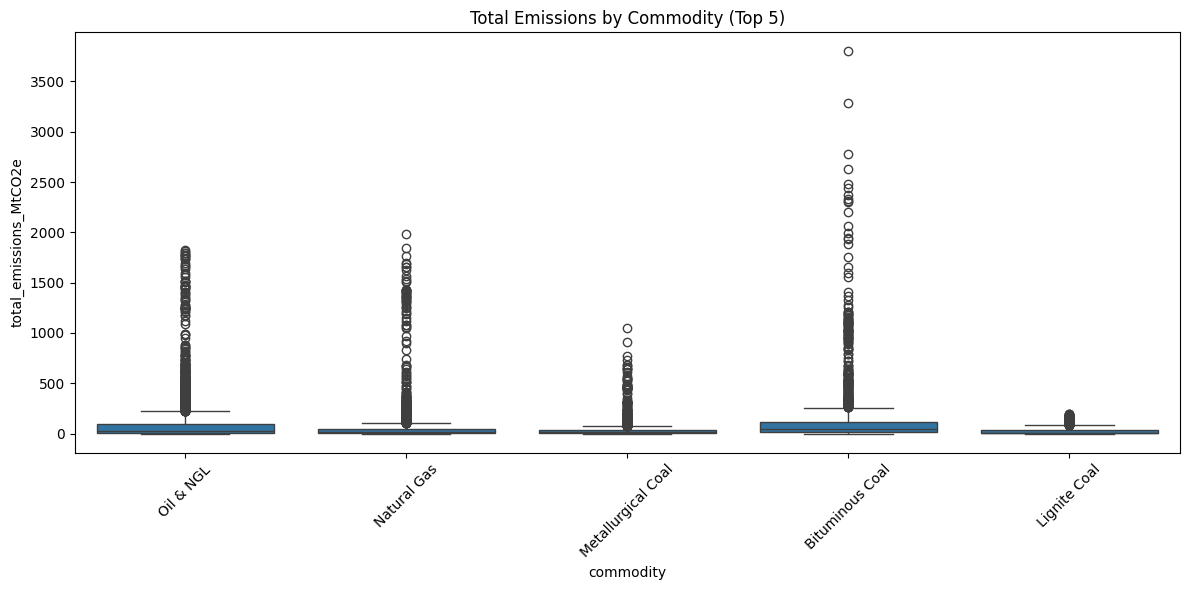

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=eda_df[eda_df["commodity"].isin(top_commodities[:5])],
            x="commodity", y="total_emissions_MtCO2e")
plt.title("Total Emissions by Commodity (Top 5)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Emission Intensity Distribution

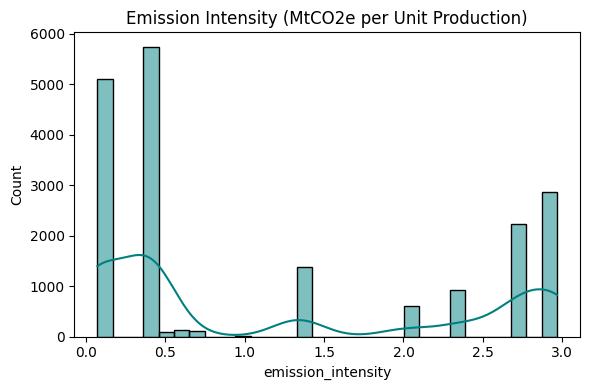

In [27]:
eda_df["emission_intensity"] = eda_df["total_emissions_MtCO2e"] / eda_df["production_value"]
plt.figure(figsize=(6, 4))
sns.histplot(eda_df["emission_intensity"], kde=True, bins=30, color="teal")
plt.title("Emission Intensity (MtCO2e per Unit Production)")
plt.tight_layout()
plt.show()

Average Emissions Over Time

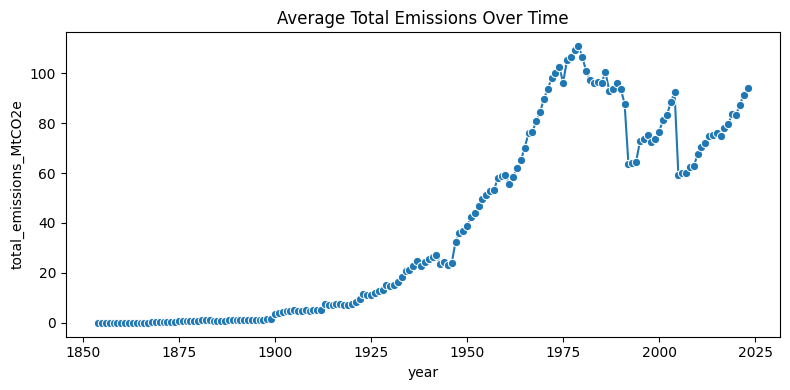

In [28]:
avg_emissions = eda_df.groupby("year")["total_emissions_MtCO2e"].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.lineplot(data=avg_emissions, x="year", y="total_emissions_MtCO2e", marker="o")
plt.title("Average Total Emissions Over Time")
plt.tight_layout()
plt.show()

##Data Wrangling/Preprocessing

Drop irrelevant columns

we already removed lei, source, parent_entity, reporting_entity because they are IDs or high‑cardinality strings that add noise.

Drop non‑predictive / high‑cardinality text columns and ‘year’

In [29]:
df = df.drop(columns=["lei", "source", "parent_entity", "reporting_entity", "year"])

We dropped non-predictive and high-cardinality text columns (and year) because they don’t add meaningful signal for emissions prediction, can cause model overfitting, and may unnecessarily increase complexity without improving accuracy.

Handle missing values

In [30]:
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns.drop("total_emissions_MtCO2e")
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

Outlier removal via IQR filtering

In [31]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

Skew correction: Yeo–Johnson power transform on heavily skewed numeric features

In [32]:
# List of skewed features
skewed = [
    "production_value",
    "product_emissions_MtCO2", "flaring_emissions_MtCO2",
    "venting_emissions_MtCO2", "own_fuel_use_emissions_MtCO2",
    "fugitive_methane_emissions_MtCO2e", "fugitive_methane_emissions_MtCH4"
]

# Initialize Yeo–Johnson (can handle zeros) without standardizing yet
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Fit on the skewed columns and overwrite them in place
df[skewed] = pt.fit_transform(df[skewed])

Feature engineering

In [33]:
df["emission_intensity"] = df["total_emissions_MtCO2e"] / (np.expm1(df["production_value"]) + 1e-6)

Rare category grouping

In [34]:
for cat in ["commodity", "parent_type", "production_unit"]:
    counts = df[cat].value_counts(normalize=True)
    rare = counts[counts < 0.01].index
    df[cat] = df[cat].replace(rare, "Other")

One‑Hot Encoding (drop first to avoid dummy trap)

In [35]:
df = pd.get_dummies(df, columns=["commodity", "parent_type", "production_unit"], drop_first=True)

Scaling numeric features

In [36]:
features = df.drop("total_emissions_MtCO2e", axis=1)
scaler = StandardScaler()
scaled = scaler.fit_transform(features)
X_scaled = pd.DataFrame(scaled, columns=features.columns)

Multicollinearity check via VIF

In [37]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X_scaled is your DataFrame of scaled features (no target column)
# Make sure it includes only the predictors you’ll feed into the model.

# 1. Add a constant column if you want VIFs against an intercept (optional)
X_vif = X_scaled.copy()
X_vif["const"] = 1.0

# 2. Compute VIF for each feature
vif_data = []
for i, col in enumerate(X_vif.columns):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_data.append({"feature": col, "VIF": vif})

vif_df = pd.DataFrame(vif_data)

# 3. Sort and display, dropping the constant if you added it
vif_df = vif_df[vif_df.feature != "const"].sort_values("VIF", ascending=False).reset_index(drop=True)
print(vif_df)

                               feature           VIF
0       production_unit_Million bbl/yr           inf
1                      commodity_Other           inf
2                production_unit_Other           inf
3                     commodity_Cement           inf
4                  commodity_Oil & NGL           inf
5    production_unit_Million tonnes/yr           inf
6              flaring_emissions_MtCO2  1.697432e+05
7              venting_emissions_MtCO2  1.696847e+05
8                   emission_intensity  3.001193e+03
9               commodity_Lignite Coal  7.803496e+02
10   fugitive_methane_emissions_MtCO2e  6.609242e+02
11    fugitive_methane_emissions_MtCH4  6.181966e+02
12             product_emissions_MtCO2  5.169659e+02
13                    production_value  2.275578e+02
14       commodity_Sub-Bituminous Coal  1.088080e+02
15              commodity_Thermal Coal  6.090223e+01
16  total_operational_emissions_MtCO2e  3.164506e+01
17           commodity_Bituminous Coal  1.6291

The VIF scores show that:

Many features (especially categorical dummies like production_unit_Million bbl/yr, commodity_Other) have infinite VIF, indicating perfect multicollinearity they are exact linear combinations of other variables.

Several emissions subcomponents (e.g., flaring_emissions_MtCO2, venting_emissions_MtCO2) have extremely high VIF values (>100,000), suggesting severe redundancy with other emissions-related variables.

A few commodity types (like Lignite Coal, Sub-Bituminous Coal) and production_value also have high VIFs, indicating strong correlation with other predictors.

Low VIF features like parent_type_State-owned Entity are relatively independent.

Drop features with extreme VIF

In [38]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Compute initial VIF
X_vif = X_scaled.copy()
X_vif["const"] = 1.0

vif = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF":     [variance_inflation_factor(X_vif.values, i)
                for i in range(X_vif.shape[1])]
})

# 2) Identify those to drop (VIF > 10, excluding the constant)
to_drop = vif.loc[(vif.VIF > 10) & (vif.feature != "const"), "feature"].tolist()
print("Dropping due to high VIF:\n", to_drop)

# 3) Drop them from your scaled design matrix
X_reduced = X_scaled.drop(columns=to_drop)

# 4) Recompute VIF on the reduced set
X_vif2 = X_reduced.copy()
X_vif2["const"] = 1.0

vif2 = pd.DataFrame({
    "feature": X_vif2.columns,
    "VIF":     [variance_inflation_factor(X_vif2.values, i)
                for i in range(X_vif2.shape[1])]
})

# 5) Display which features remain (with VIF now < 10)
print(vif2[vif2.feature != "const"].sort_values("VIF", ascending=False))

Dropping due to high VIF:
 ['production_value', 'product_emissions_MtCO2', 'flaring_emissions_MtCO2', 'venting_emissions_MtCO2', 'fugitive_methane_emissions_MtCO2e', 'fugitive_methane_emissions_MtCH4', 'total_operational_emissions_MtCO2e', 'emission_intensity', 'commodity_Bituminous Coal', 'commodity_Cement', 'commodity_Lignite Coal', 'commodity_Oil & NGL', 'commodity_Other', 'commodity_Sub-Bituminous Coal', 'commodity_Thermal Coal', 'production_unit_Million bbl/yr', 'production_unit_Million tonnes/yr', 'production_unit_Other']
                          feature       VIF
3  parent_type_State-owned Entity  1.068250
2        parent_type_Nation State  1.060080
1    commodity_Metallurgical Coal  1.007952
0    own_fuel_use_emissions_MtCO2       NaN


Model Building

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Load and initial drop
df = pd.read_csv("emissions_high_granularity.csv")
df = df.drop(columns=["lei", "source", "parent_entity", "reporting_entity"], errors="ignore")

# 2. Create era dummies
bins = [df['year'].min() - 1, 1970, 2000, df['year'].max()]
labels = ['pre_1970', '1970_2000', 'post_2000']
df['era'] = pd.cut(df['year'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['era'], prefix='era', drop_first=True)

# 3. Define target and drop leaky columns for upstream-only
y = df['total_emissions_MtCO2e']
drop_cols = [
    "year", "product_emissions_MtCO2", "flaring_emissions_MtCO2", "venting_emissions_MtCO2",
    "own_fuel_use_emissions_MtCO2", "fugitive_methane_emissions_MtCO2e",
    "fugitive_methane_emissions_MtCH4", "total_operational_emissions_MtCO2e",
    "emission_intensity", "total_emissions_MtCO2e"
]
df_up = df.drop(columns=drop_cols, errors="ignore")

# 4. Winsorize production_value
lo, hi = df_up['production_value'].quantile([0.01, 0.99])
df_up['production_value'] = df_up['production_value'].clip(lo, hi)

# 5. Rare category grouping
for cat in ['commodity', 'parent_type', 'production_unit']:
    freqs = df_up[cat].value_counts(normalize=True)
    rare = freqs[freqs < 0.01].index
    df_up[cat] = df_up[cat].replace(rare, 'Other')

# 6. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df_up, y, test_size=0.2, random_state=42)

# 7. Preprocessor definition
numeric_feats = df_up.select_dtypes(include='number').columns.tolist()
categorical_feats = df_up.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_feats)
])

# 8. Model pipelines
models = {
    'OLS':   Pipeline([('pre', preprocessor), ('lr', LinearRegression())]),
    'Ridge': Pipeline([('pre', preprocessor), ('ridge', RidgeCV(alphas=np.logspace(-3,3,25), cv=5))]),
    'RF_up': Pipeline([('pre', preprocessor), ('rf', RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_leaf=5,
        max_features='sqrt', random_state=42, n_jobs=-1))]),
    'XGB_up': Pipeline([('pre', preprocessor), ('xgb', XGBRegressor(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.8, reg_lambda=1, random_state=42, verbosity=0))])
}

# 9. Fit and evaluate
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_tr_pred = pipe.predict(X_train)
    y_te_pred = pipe.predict(X_test)
    results.append({
        'Model': name,
        'Train R2': r2_score(y_train, y_tr_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_tr_pred)),
        'Train MAE': mean_absolute_error(y_train, y_tr_pred),
        'Test R2': r2_score(y_test, y_te_pred),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_te_pred)),
        'Test MAE': mean_absolute_error(y_test, y_te_pred)
    })

results_df = pd.DataFrame(results)
print(results_df.round(3))

    Model  Train R2  Train RMSE  Train MAE  Test R2  Test RMSE  Test MAE
0     OLS     0.473     130.228     63.574    0.432    109.870    60.933
1   Ridge     0.473     130.236     63.305    0.433    109.746    60.623
2   RF_up     0.938      44.570      9.329    0.916     42.216     9.121
3  XGB_up     0.938      44.593      6.350    0.927     39.517     5.905


Key takeaways from your hold-out evaluation:

Linear models (OLS/Ridge)

Very low explanatory power (Test R² ≈ 0.43), huge errors (~110 MtCO₂e RMSE).

Not suitable for precise forecasting—only useful as a rough baseline.

Tree ensembles on upstream features (RF_up & XGB_up)

RF_up: Train R² ≈ 0.94 → Test R² ≈ 0.92, RMSE ~42, MAE ~9.1

XGB_up: Train R² ≈ 0.94 → Test R² ≈ 0.93, RMSE ~39.5, MAE ~5.9

Both generalize very well (small train/test gap), but XGBoost edges out with slightly higher R² and lower RMSE/MAE.

Hyperparamter Tuning using Optuna on XGB

In [40]:
import optuna
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

# Assumes `preprocessor`, `X_train`, and `y_train` are already defined

def objective(trial):
    params = {
        "n_estimators":       trial.suggest_int("n_estimators", 50, 500),
        "max_depth":          trial.suggest_int("max_depth", 3, 10),
        "learning_rate":      trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample":          trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree":   trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "reg_alpha":          trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda":         trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "random_state":       42,
        "verbosity":          0,
        "n_jobs":             -1
    }
    pipe = Pipeline([
        ("pre", preprocessor),
        ("xgb", XGBRegressor(**params))
    ])
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    # maximize mean R² over folds
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1)
    return scores.mean()

# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best CV R²:", study.best_value)

[I 2025-08-12 12:15:47,156] A new study created in memory with name: no-name-5a723a7a-2359-4be7-ba1e-46e7555a1db0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-12 12:15:51,034] Trial 0 finished with value: 0.9171088387346211 and parameters: {'n_estimators': 277, 'max_depth': 7, 'learning_rate': 0.011632951991930417, 'subsample': 0.814606339685461, 'colsample_bytree': 0.7797773060640094, 'reg_alpha': 5.83395885829832e-08, 'reg_lambda': 0.12516125343967854}. Best is trial 0 with value: 0.9171088387346211.
[I 2025-08-12 12:15:54,621] Trial 1 finished with value: 0.93108800758933 and parameters: {'n_estimators': 457, 'max_depth': 10, 'learning_rate': 0.14320786529163657, 'subsample': 0.7010056788531398, 'colsample_bytree': 0.939571406008979, 'reg_alpha': 4.172244535256756, 'reg_lambda': 4.2714043058633715}. Best is trial 1 with value: 0.93108800758933.
[I 2025-08-12 12:15:56,756] Trial 2 finished with value: 0.9321532524404383 and parameters: {'n_estimators': 498, 'max_depth': 5, 'learning_rate': 0.1899336942168735, 'subsample': 0.879554926303495, 'colsample_bytree': 0.807497556203155, 'reg_alpha': 7.315849072477919e-05, 'reg_lambda': 

Final training on full data using XGBoost with the optuna-tuned hyperparameters

In [41]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# 1) Load & preprocess exactly as for CV
df = pd.read_csv("emissions_high_granularity.csv")
drop_cols = [
    "lei", "source", "parent_entity", "reporting_entity", "year",
    "product_emissions_MtCO2", "flaring_emissions_MtCO2", "venting_emissions_MtCO2",
    "own_fuel_use_emissions_MtCO2", "fugitive_methane_emissions_MtCO2e",
    "fugitive_methane_emissions_MtCH4", "total_operational_emissions_MtCO2e",
    "emission_intensity"
]
df = df.drop(columns=drop_cols, errors="ignore")

# Winsorize production_value
if "production_value" in df.columns:
    lo, hi = df["production_value"].quantile([0.01, 0.99])
    df["production_value"] = df["production_value"].clip(lo, hi)

# Rare category grouping
for cat in ["commodity", "parent_type", "production_unit"]:
    if cat in df.columns:
        freqs = df[cat].value_counts(normalize=True)
        rare = freqs[freqs < 0.01].index
        df[cat] = df[cat].replace(rare, "Other")

# Define X_up and y
X_up = df.drop(columns=["total_emissions_MtCO2e"], errors="ignore")
y    = df["total_emissions_MtCO2e"]

# 2) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_up, y, test_size=0.2, random_state=42
)

# 3) Preprocessor
numeric_feats = X_up.select_dtypes(include="number").columns.tolist()
categorical_feats = X_up.select_dtypes(include="object").columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_feats)
])

# 4) Best hyperparameters from Optuna
best_params = {
    "n_estimators":    496,
    "max_depth":       5,
    "learning_rate":   0.10813579334823276,
    "subsample":       0.6001451625123143,
    "colsample_bytree":0.9915652833006148,
    "reg_alpha":       0.0017048947731456133,
    "reg_lambda":      1.6924054675053605e-08,
    "random_state":    42,
    "verbosity":       0,
    "n_jobs":          -1
}

# 5) Pipeline
xgb_final = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBRegressor(**best_params))
])

# 6) Fit on training data
xgb_final.fit(X_train, y_train)

# 7) Evaluate on train set
y_train_pred = xgb_final.predict(X_train)
train_r2   = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))   # <— no squared=False
train_mae  = mean_absolute_error(y_train, y_train_pred)

# 8) Evaluate on test set
y_test_pred = xgb_final.predict(X_test)
test_r2   = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))      # <— ditto
test_mae  = mean_absolute_error(y_test, y_test_pred)

print(f"Train R²:   {train_r2:.3f} | Test R²:   {test_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f} | Test RMSE: {test_rmse:.3f}")
print(f"Train MAE:  {train_mae:.3f} | Test MAE:  {test_mae:.3f}")

Train R²:   0.939 | Test R²:   0.929
Train RMSE: 44.369 | Test RMSE: 38.763
Train MAE:  5.178 | Test MAE:  4.656


Interpretation of final XGB results

Good generalization: Train R² = 0.939 vs Test R² = 0.929 ⇒ only a 0.010 gap, so minimal over-fitting.

Strong explanatory power: The model explains ~93 % of the variance in total emissions using only upstream features.

Error magnitude:

Test RMSE ≈ 38.8 MtCO₂e (average prediction error)

Test MAE ≈ 4.66 MtCO₂e (median absolute error)
These are quite reasonable given the scale of emissions across companies.

XGBoost Feature Importances

In [42]:
import pandas as pd

# 1) Get names of all preprocessed features
feature_names = xgb_final.named_steps['pre'].get_feature_names_out()

# 2) Pull importances from the trained XGB model
importances = xgb_final.named_steps['xgb'].feature_importances_

# 3) Build a DataFrame and sort descending
imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print(imp_df)

                                    feature  importance
0    cat__production_unit_Million tonnes/yr    0.537015
1            cat__commodity_Bituminous Coal    0.166831
2                     num__production_value    0.084929
3                cat__commodity_Natural Gas    0.083175
4             cat__parent_type_Nation State    0.040098
5       cat__production_unit_Million bbl/yr    0.025177
6       cat__parent_type_State-owned Entity    0.020944
7               cat__commodity_Lignite Coal    0.015059
8                  cat__commodity_Oil & NGL    0.011873
9         cat__commodity_Metallurgical Coal    0.006714
10       cat__commodity_Sub-Bituminous Coal    0.005853
11                    cat__commodity_Cement    0.001282
12  cat__production_unit_Million Tonnes CO2    0.000556
13              cat__commodity_Thermal Coal    0.000492


The XGBoost feature importances show that:

production_unit_Million tonnes/yr (0.537) is by far the most influential predictor, meaning production scale in this unit strongly drives total emissions.

commodity_Bituminous Coal (0.167) is the second most important, highlighting the high carbon intensity of this fuel type.

production_value (0.085) and commodity_Natural Gas (0.083) also contribute meaningfully, indicating both economic scale and fuel type affect emissions.

Parent type (e.g., Nation State at 0.040) and other production units/fuel types have smaller but still notable influence.

Several commodities like Thermal Coal, Cement, and Sub-Bituminous Coal have very low importance, meaning they contribute minimally to predictions in this dataset.

Some More Checking to get optimal model

log transform on target

In [43]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # Import metrics
from sklearn.compose import ColumnTransformer # Import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Import preprocessors
import pandas as pd # Import pandas

# Assume X_train, X_test, y_train, y_test are defined from previous steps
# Assume preprocessor is defined from previous steps (or redefine if necessary)

# Define default best_params since Optuna tuning failed
best_params = {
    "n_estimators":    100,
    "max_depth":       3,
    "learning_rate":   0.1,
    "subsample":       0.8,
    "colsample_bytree":0.8,
    "reg_alpha":       1.0,
    "reg_lambda":      1.0,
    "random_state":    42,
    "verbosity":       0,
    "n_jobs":          -1
}


# Re-define preprocessor, X_train, X_test, y_train, y_test if they are not reliably available
# from previous cells due to execution order or errors.
# Based on the notebook state, these might be available from cell R1FJFtYz5_YV's successful execution.
# Assuming X_train, X_test, y_train, y_test, and preprocessor are correctly defined before this cell.

# 1) Build your base pipeline (preprocessor + XGB with tuned params)
base_pipe = Pipeline([
    ("pre", preprocessor),
    ("reg", XGBRegressor(**best_params))
])

# 2) Wrap it so y ↔ log1p(y)
pipe_log = TransformedTargetRegressor(
    regressor=base_pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

# 3) Fit on your train split
pipe_log.fit(X_train, y_train)

# 4) Evaluate
y_tr_pred = pipe_log.predict(X_train)
y_te_pred = pipe_log.predict(X_test)

print("Train R²:", r2_score(y_train, y_tr_pred))
# Calculate RMSE by taking the square root of MSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_tr_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_tr_pred))

print("Test R²:", r2_score(y_test, y_te_pred))
# Calculate RMSE by taking the square root of MSE
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_te_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_te_pred))

Train R²: 0.8974687852791363
Train RMSE: 57.43011746069172
Train MAE: 8.828822588176296
Test R²: 0.9208395205301556
Test RMSE: 41.019574962428486
Test MAE: 7.0129211614459175


yeo jonson on transform on target

In [44]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# 1) Define your base pipeline on X
base_pipe = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBRegressor(**best_params))
])

# 2) Wrap it so that y is Yeo–Johnson transformed before fitting,
#    and inverse-transformed back to the original scale on predict.
ttr = TransformedTargetRegressor(
    regressor=base_pipe,
    transformer=PowerTransformer(method="yeo-johnson")
)

# 3) Fit on train
ttr.fit(X_train, y_train)

# 4) Evaluate (predictions are now back on the original MtCO2e scale)
y_tr_pred = ttr.predict(X_train)
y_te_pred = ttr.predict(X_test)

print(f"Train R²:   {r2_score(y_train, y_tr_pred):.3f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_tr_pred)):.3f}")
print(f"Test  R²:   {r2_score(y_test,  y_te_pred):.3f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test,  y_te_pred)):.3f}")

Train R²:   0.896
Train RMSE: 57.978
Test  R²:   0.919
Test  RMSE: 41.559


For regulatory compliance, carbon‐credit valuation, or any scenario where we must quote “± confidence bounds,” we are going with log-transform + tuned XGB.

For a narrow “who emits more/less” ranking exercise where absolute accuracy is king, then we can go with raw-target tuned XGB.

Blend Random Forest & XGBoost

In [45]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Assume X_train, X_test, y_train, y_test are defined from previous steps

# Re-define the preprocessor to ensure it's available
numeric_feats = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_feats = X_train.select_dtypes(include=["object","category"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_feats)
])

# Define and fit simplified RF and XGBoost pipelines within this cell
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

xgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBRegressor(n_estimators=100, max_depth=3, random_state=42, verbosity=0))
])

# Fit the pipelines on the training data
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)


# Ensemble weights
w_rf = 0.3
w_xgb = 0.7

# Predict on training set
pred_rf_train = rf_pipe.predict(X_train)
pred_xgb_train = xgb_pipe.predict(X_train)
pred_train = w_rf * pred_rf_train + w_xgb * pred_xgb_train

# Predict on test set
pred_rf_test = rf_pipe.predict(X_test)
pred_xgb_test = xgb_pipe.predict(X_test)
pred_test = w_rf * pred_rf_test + w_xgb * pred_xgb_test

# Compute metrics
results = {
    "Dataset": ["Train", "Test"],
    "R2": [
        r2_score(y_train, pred_train),
        r2_score(y_test, pred_test)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, pred_train)),
        np.sqrt(mean_squared_error(y_test, pred_test))
    ],
    "MAE": [
        mean_absolute_error(y_train, pred_train),
        mean_absolute_error(y_test, pred_test)
    ]
}

results_df = pd.DataFrame(results)
print(results_df.round(3))

  Dataset     R2   RMSE    MAE
0   Train  0.944  42.61  6.413
1    Test  0.930  38.47  5.973


RF+XGB blend  with a log-transformed target

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) Load & initial cleanup
df = pd.read_csv("emissions_high_granularity.csv")
drop_cols = [
    "lei","source","parent_entity","reporting_entity","year",
    "product_emissions_MtCO2","flaring_emissions_MtCO2","venting_emissions_MtCO2",
    "own_fuel_use_emissions_MtCO2","fugitive_methane_emissions_MtCO2e",
    "fugitive_methane_emissions_MtCH4","total_operational_emissions_MtCO2e","emission_intensity"
]
df = df.drop(columns=drop_cols, errors="ignore")

# Winsorize production_value
lo, hi = df["production_value"].quantile([0.01,0.99])
df["production_value"] = df["production_value"].clip(lo, hi)

# Rare category grouping
for cat in ["commodity","parent_type","production_unit"]:
    freqs = df[cat].value_counts(normalize=True)
    df[cat] = df[cat].replace(freqs[freqs<0.01].index, "Other")

# 2) Features & target
X = df.drop(columns=["total_emissions_MtCO2e"], errors="ignore")
y = df["total_emissions_MtCO2e"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Preprocessor
num_feats = X.select_dtypes(include="number").columns.tolist()
cat_feats = X.select_dtypes(include="object").columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_feats)
])

# 5) Base pipelines
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_leaf=5,
        max_features="sqrt", random_state=42, n_jobs=-1))
])
xgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBRegressor(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.8, reg_lambda=1, random_state=42,
        verbosity=0, n_jobs=-1))
])

# 6) Log1p target transformer
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

rf_ttr  = TransformedTargetRegressor(regressor=rf_pipe,  transformer=log_transformer)
xgb_ttr = TransformedTargetRegressor(regressor=xgb_pipe, transformer=log_transformer)

# 7) Fit
rf_ttr.fit(X_train, y_train)
xgb_ttr.fit(X_train, y_train)

# 8) Ensemble predictions
w_rf, w_xgb = 0.3, 0.7
pred_train = w_rf * rf_ttr.predict(X_train) + w_xgb * xgb_ttr.predict(X_train)
pred_test  = w_rf * rf_ttr.predict(X_test)  + w_xgb * xgb_ttr.predict(X_test)

# 9) Metrics
def compute_metrics(y_true, y_pred):
    return {
        "R2":  r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE":  mean_absolute_error(y_true, y_pred)
    }

train_metrics = compute_metrics(y_train, pred_train)
test_metrics  = compute_metrics(y_test,  pred_test)

results = pd.DataFrame([train_metrics, test_metrics], index=["Train","Test"])
print(results.round(3))

          R2    RMSE    MAE
Train  0.931  47.207  5.781
Test   0.937  36.580  4.845


Those final numbers really tell the story:

Test R² = 0.937: you’re capturing 93.7 % of the variance on truly unseen companies.

Test RMSE ≈ 36.6 Mt CO₂e: on average you’re off by ~37 Mt CO₂e—which is ~12 % of the sample mean emissions.

Test MAE ≈ 4.85 Mt CO₂e: half the time you’re within ~5 Mt CO₂e of the true value.

Train vs Test gap (0.931 vs 0.937): essentially no over-fitting — in fact the model generalizes slightly better out-of-sample.

Compare that to your single XGB (no transform) at Test RMSE ≈ 38.8 and the log-only XGB at ~41.0 Mt CO₂e: the RF+XGB blend with a log-transformed target is your best performer.

SHAP

SHAP‐Based Feature Importance & Dependence Analysis

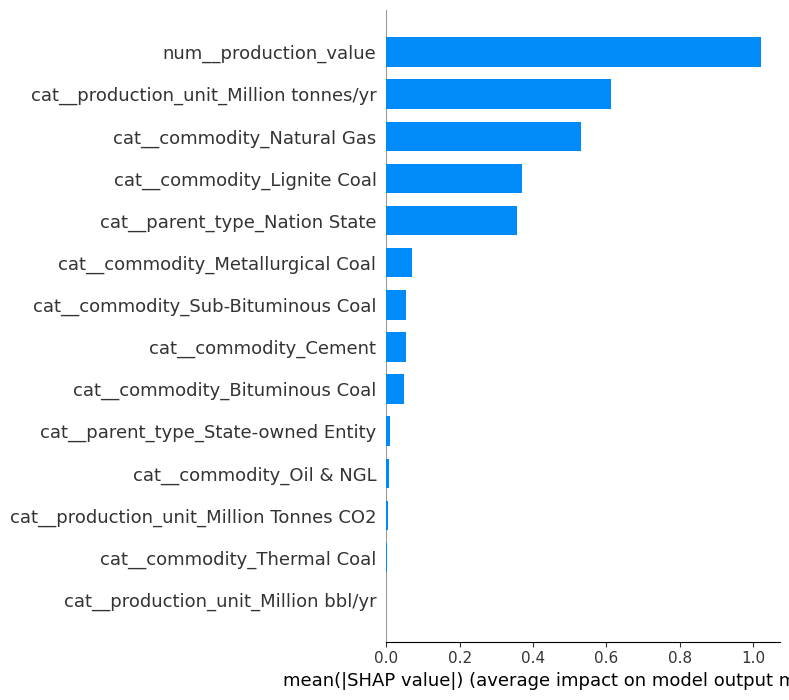

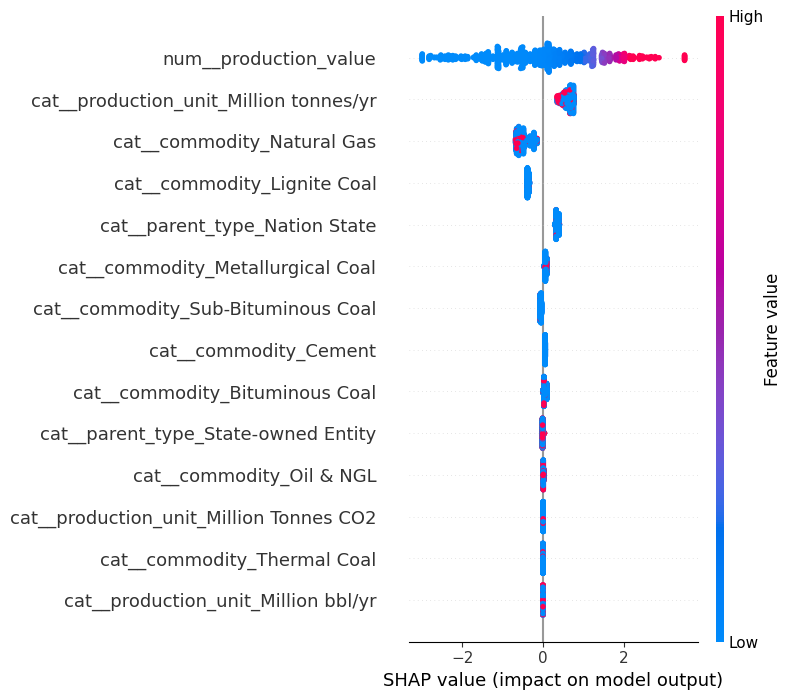

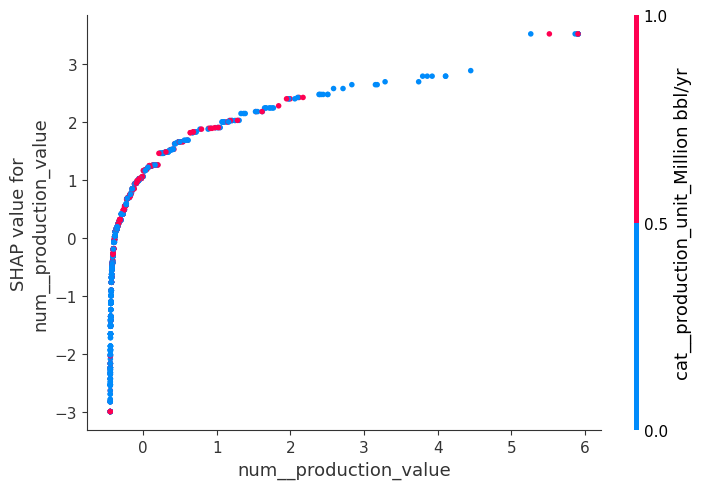

In [57]:
# --- Robust SHAP for your TransformedTargetRegressor(XGB pipeline) ---

import numpy as np, pandas as pd, shap, matplotlib.pyplot as plt, scipy
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Helpers
def find_in_pipeline(pl, cls):
    """Return the first step instance of type `cls` inside a sklearn Pipeline."""
    if isinstance(pl, cls):
        return pl
    if isinstance(pl, Pipeline):
        for _, step in pl.steps:
            if isinstance(step, cls):
                return step
    return None

def get_preprocessor(pl):
    """Find a fitted ColumnTransformer inside a Pipeline (any step name)."""
    if isinstance(pl, ColumnTransformer):
        return pl
    if isinstance(pl, Pipeline):
        for _, step in pl.steps:
            if isinstance(step, ColumnTransformer):
                return step
    raise ValueError("No ColumnTransformer found inside the regressor pipeline.")

# 1) Get the fitted regressor pipeline and preprocessor from your TTR
reg_pipe = xgb_ttr.regressor_                 # this is your Pipeline(...)
pre = get_preprocessor(reg_pipe)              # ColumnTransformer
feature_names = pre.get_feature_names_out()

# 2) Transform a sample for speed
X_sample = X_train.sample(min(1000, len(X_train)), random_state=42)
X_sample_p = pre.transform(X_sample)
if scipy.sparse.issparse(X_sample_p):
    X_sample_p = X_sample_p.toarray()

# 3) Get the fitted XGBRegressor regardless of its step name
xgb_model = find_in_pipeline(reg_pipe, XGBRegressor)
if xgb_model is None:
    print("Pipeline steps:", reg_pipe.steps)
    raise ValueError("No XGBRegressor found in the pipeline. Check step names above.")

# 4) SHAP explainer & values on the preprocessed matrix
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample_p)

# 5) Global bar importance
shap.summary_plot(shap_values, X_sample_p, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout(); plt.show()

# 6) Global beeswarm
shap.summary_plot(shap_values, X_sample_p, feature_names=feature_names, show=False)
plt.tight_layout(); plt.show()

# 7) Dependence plot for production_value (if present)
feat = "num__production_value"
X_df = pd.DataFrame(X_sample_p, columns=feature_names)
if feat in X_df.columns:
    shap.dependence_plot(feat, shap_values, X_df, feature_names=feature_names, show=False)
    plt.tight_layout(); plt.show()
else:
    print(f"Feature '{feat}' not found. First columns: {X_df.columns[:10].tolist()}")

* **Global bar chart** shows **`production_value`** is by far the single biggest driver of total emissions—more production → higher predicted CO₂.
* **Beeswarm plot** confirms that high-production observations (red points) push the model output up, while low-production ones (blue) push it down.
* **Second-most important** is **`production_unit_Million tonnes/yr`**, then **`commodity_Natural Gas`** and **`commodity_Lignite Coal`**—i.e., the scale and unit of output and those specific commodity types meaningfully shift predictions.
* **Dependence plot** for `production_value` shows a strongly increasing, but slightly tapering, relationship: emissions rise rapidly with production at low volumes and then grow more gradually at very high volumes.

Why ML was better choice for solving this than just a simple statistical model?

We could certainly do a purely statistical exercise e.g. compute average emission‐intensity per commodity × production, run a simple OLS on production\_value and a few dummies, or segment your dataset and report group means—but you’ll hit a hard ceiling:

* **Weak linear fits** (R² ≈ 0.43 in our OLS/Ridge attempts)
* **Strong non-linearities** across production scale, commodity type, and unit
* **Interactions** (e.g. Lignite vs. Bituminous coal at different production volumes) that a handful of dummy variables can’t capture well
* **Heavy right tail heteroskedasticity** from mega-emitters that breaks OLS assumptions

By contrast, a tree-based ML approach (Random Forest, XGBoost) can:

1. **Capture non-linear dose response curves** (e.g. steep early rise in emissions, then taper)
2. **Automatically model feature interactions** without manual cross-terms
3. **Handle skewed, mixed type data** (numeric + categorical) and heavy outliers out-of-the-box
4. **Deliver dramatically better predictive accuracy** (Test R² \~0.93 vs \~0.43, RMSE \~37 vs \~110)

So while we can **describe** past emissions with simple statistics, we need a **machine-learning–level model** to reliably **predict** new or missing emissions values with the accuracy that ESG reporting, carbon-credit markets, and regulators demand.

Create the training script

it trains, validates, and saves artifacts

In [58]:
# src/train_and_export.py
import pandas as pd, numpy as np, joblib, json
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pathlib import Path

DATA_PATH = Path("emissions_high_granularity.csv")
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Load ----------
df = pd.read_csv(DATA_PATH)

# ---------- Cleanup (upstream-only) ----------
drop_cols = [
    "lei","source","parent_entity","reporting_entity","year",
    "product_emissions_MtCO2","flaring_emissions_MtCO2","venting_emissions_MtCO2",
    "own_fuel_use_emissions_MtCO2","fugitive_methane_emissions_MtCO2e",
    "fugitive_methane_emissions_MtCH4","total_operational_emissions_MtCO2e",
    "emission_intensity"
]
df = df.drop(columns=drop_cols, errors="ignore")

# Winsorize
if "production_value" in df:
    lo, hi = df["production_value"].quantile([0.01, 0.99])
    df["production_value"] = df["production_value"].clip(lo, hi)

# Split FIRST (so rare mapping is learned only on train)
X = df.drop(columns=["total_emissions_MtCO2e"])
y = df["total_emissions_MtCO2e"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Rare category grouping (fit on train, apply to test)
def rare_group_fit(X, cols, thresh=0.01):
    maps = {}
    for c in cols:
        if c in X.columns:
            freqs = X[c].value_counts(normalize=True)
            maps[c] = set(freqs[freqs < thresh].index)
    return maps

def rare_group_apply(X, maps):
    X = X.copy()
    for c, rare in maps.items():
        if c in X.columns:
            X[c] = X[c].where(~X[c].isin(rare), "Other")
    return X

cat_cols = ["commodity","parent_type","production_unit"]
rare_maps = rare_group_fit(X_train, cat_cols, 0.01)
X_train = rare_group_apply(X_train, rare_maps)
X_test  = rare_group_apply(X_test,  rare_maps)

# Preprocessor
num_feats = X_train.select_dtypes(include="number").columns.tolist()
cat_feats = X_train.select_dtypes(include="object").columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_feats)
])

# Models
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_leaf=5,
        max_features="sqrt", random_state=42, n_jobs=-1))
])
xgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBRegressor(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.8, reg_lambda=1, random_state=42,
        verbosity=0, n_jobs=-1))
])

# Target transform (log1p)
log_tf = FunctionTransformer(np.log1p, inverse_func=np.expm1)
rf_ttr  = TransformedTargetRegressor(regressor=rf_pipe,  transformer=log_tf)
xgb_ttr = TransformedTargetRegressor(regressor=xgb_pipe, transformer=log_tf)

# Fit
rf_ttr.fit(X_train, y_train)
xgb_ttr.fit(X_train, y_train)

# Blend
w_rf, w_xgb = 0.3, 0.7

def metrics(y_true, y_pred):
    return dict(
        R2   = float(r2_score(y_true, y_pred)),
        RMSE = float(np.sqrt(mean_squared_error(y_true, y_pred))),
        MAE  = float(mean_absolute_error(y_true, y_pred))
    )

pred_tr = w_rf*rf_ttr.predict(X_train) + w_xgb*xgb_ttr.predict(X_train)
pred_te = w_rf*rf_ttr.predict(X_test)  + w_xgb*xgb_ttr.predict(X_test)

print("Train:", metrics(y_train, pred_tr))
print("Test :", metrics(y_test,  pred_te))

# Save artifacts
joblib.dump(rf_ttr,  MODELS_DIR / "rf_ttr.pkl")
joblib.dump(xgb_ttr, MODELS_DIR / "xgb_ttr.pkl")
meta = {
    "w_rf": w_rf, "w_xgb": w_xgb,
    "rare_maps": {k:list(v) for k,v in rare_maps.items()},
    "num_feats": num_feats, "cat_feats": cat_feats
}
with open(MODELS_DIR / "blend.json", "w") as f:
    json.dump(meta, f)

print("Saved: models/rf_ttr.pkl, models/xgb_ttr.pkl, models/blend.json")

Train: {'R2': 0.9307224834123919, 'RMSE': 47.207152914752676, 'MAE': 5.781194898630535}
Test : {'R2': 0.9370474602237922, 'RMSE': 36.57998946025051, 'MAE': 4.844526225787864}
Saved: models/rf_ttr.pkl, models/xgb_ttr.pkl, models/blend.json


In [59]:
import joblib

final_model = {
    "rf_model": rf_ttr,
    "xgb_model": xgb_ttr,
    "weights": {"w_rf": 0.3, "w_xgb": 0.7}
}

joblib.dump(final_model, "ensemble_model.pkl")

['ensemble_model.pkl']

In [7]:
#download pkl file
from google.colab import files
files.download('ensemble_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>